In [1]:
import os
import time
import string
import pickle
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

from keras.models import Model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras_self_attention import SeqSelfAttention
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, LSTM, Dense, Flatten, Embedding, Add, RepeatVector, TimeDistributed, Concatenate
from keras import optimizers

from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_url = "text/Flickr_8k.trainImages.txt"
test_url = "text/Flickr_8k.testImages.txt"
token_url = "text/Flickr8k.token.txt"
image_url = "Flicker8k_Dataset/"

In [3]:
train = pd.read_csv(train_url, header=None, names=["image"])
test = pd.read_csv(test_url, header=None, names=["image"])
token = pd.read_csv(token_url, header=None, sep="\t", names=["image", "caption"])

In [4]:
pic_size = 224
batch_size = 32
epochs = 5

In [5]:
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans(string.punctuation,"                                "))
    return(text_no_punctuation)
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

In [6]:
token[["image","index"]] = token["image"].str.split("#", expand=True)
token["caption"] = token["caption"].apply(lambda x: text_clean(x))
# token = token[token["index"] == "0"]
token = token.drop("index", axis=1)

train = pd.merge(train, token, on="image")
train["caption"] = train["caption"].apply(lambda x: "startseq " + x + " endseq")
test = pd.merge(test, token, on="image")
test["caption"] = test["caption"].apply(lambda x: "startseq " + x + " endseq")

In [7]:
img_model = ResNet50(weights='imagenet', include_top=False, input_shape = (pic_size, pic_size, 3))
img_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [8]:
def extract_image(model, df_image, image_url):    
    counter = 0
    img_encoding = {}
    for name in df_image:
        if name not in img_encoding:
            counter += 1
            filename = image_url + name    
            image = load_img(filename, target_size=(pic_size,pic_size,3))
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)
            pred = model.predict(image)
            img_encoding[name] = pred.flatten()
            if counter % 1000 == 0:
                print ("Encoding image: "+str(counter),pred.flatten().shape)          
    with open("extract_image.p", "wb" ) as pickle_f:
        pickle.dump(img_encoding, pickle_f )         
    return  img_encoding       

In [9]:
img_encoding = extract_image(img_model,train["image"], image_url)

Encoding image: 1000 (2048,)
Encoding image: 2000 (2048,)
Encoding image: 3000 (2048,)
Encoding image: 4000 (2048,)
Encoding image: 5000 (2048,)
Encoding image: 6000 (2048,)


In [10]:
# img_encoding = pickle.load(open( "extract_image.p", "rb" ))

In [11]:
def word_tokenizer(df):
    tokenizer = Tokenizer(num_words=8000)
    dcaptions = df["caption"].values
    tokenizer.fit_on_texts(dcaptions)
    vocab_size = len(tokenizer.word_index) + 1
    dtexts = tokenizer.texts_to_sequences(dcaptions)
    df["token_caption"] = dtexts    
    maxlen = np.max([len(text) for text in dtexts])
    
    print("vocabulary size : {}".format(vocab_size))    
    print("max length : {}".format(maxlen))    
    return df, vocab_size, maxlen

In [12]:
trained, vocab_size, maxlen = word_tokenizer(train)
trained.head()

vocabulary size : 7319
max length : 35


,image,caption,token_caption
0,2513260012_03d33305cf.jpg,startseq black dog is running after white dog...,"[1, 14, 8, 6, 31, 255, 13, 8, 3, 4, 41, 2]"
1,2513260012_03d33305cf.jpg,startseq Black dog chasing brown dog through ...,"[1, 14, 8, 256, 24, 8, 32, 41, 2]"
2,2513260012_03d33305cf.jpg,startseq Two dogs chase each other across the...,"[1, 12, 30, 816, 137, 83, 126, 4, 138, 164, 2]"
3,2513260012_03d33305cf.jpg,startseq Two dogs play together in the snow e...,"[1, 12, 30, 81, 141, 3, 4, 41, 2]"
4,2513260012_03d33305cf.jpg,startseq Two dogs running through low lying b...,"[1, 12, 30, 31, 32, 533, 446, 257, 11, 23, 2]"


In [13]:
def split_data(df, ratio):
    df = shuffle(df)
    ratio = round(df.shape[0] * (1-ratio))
    print("ratio: ",ratio)
    return df[:ratio], df[ratio:]

In [14]:
train_data, val_data = split_data(trained, 0.1)
train_data.shape, val_data.shape

ratio:  27000


((27000, 3), (3000, 3))

In [15]:
def data_generator(df, img_encoding, batch_size, vocab_size, maxlen):
    df = shuffle(df)
    x_batch_text, x_batch_image, y_batch_text = [],[],[]
    total_count = 0
    while True:
        for i,row in df.iterrows():
            total_count += 1
            img = img_encoding[row["image"]]
            token_caption = row["token_caption"]
            for i in range(1,len(token_caption)):
                x_text, y_text = token_caption[:i], token_caption[i]
                x_text = pad_sequences([x_text],maxlen=maxlen).flatten()
                y_text = to_categorical(y_text,num_classes = vocab_size)                
                x_batch_text.append(x_text)
                x_batch_image.append(img)
                y_batch_text.append(y_text)
            if total_count >= batch_size:
                x_batch_text = np.array(x_batch_text) 
                x_batch_image = np.array(x_batch_image) 
                y_batch_text = np.array(y_batch_text)
                total_count = 0
#                     print("x_batch_text :{}, x_batch_image: {}, y_batch_text: {}".format(x_batch_text.shape,x_batch_image.shape,y_batch_text.shape))
                yield [[x_batch_text, x_batch_image], y_batch_text]
                x_batch_text, x_batch_image, y_batch_text = [],[],[]

In [16]:
datagenerator = data_generator(train_data, img_encoding, batch_size, vocab_size, maxlen)
batch_data = next(datagenerator)
x_batch_text, x_batch_image, y_batch_text = batch_data[0][0], batch_data[0][1], batch_data[1]
x_batch_text.shape, x_batch_image.shape, y_batch_text.shape

((321, 35), (321, 2048), (321, 7319))

In [17]:
def create_model(x_batch_image_shape, maxlen, vocab_size):
    
    input_image = Input(shape=(x_batch_image_shape,), name="img_input")
    fimage = Dense(256,activation='relu',name="ImageFeature")(input_image)
    
    
    input_txt = Input(shape=(maxlen,),name="text_input")
    ftxt = Embedding(vocab_size,64, mask_zero=True)(input_txt)
#     ftxt = SeqSelfAttention()(ftxt)  
    ftxt = LSTM(256,name="CaptionFeature")(ftxt)
   

    decoder = Add()([ftxt,fimage])  
    decoder = Dense(256,activation='relu')(decoder)
    output = Dense(vocab_size,activation='softmax')(decoder)  
    
    model = Model(inputs=[input_txt, input_image],outputs=output)

    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.adam(lr=1e-3),
                  metrics=['accuracy'])

    print(model.summary())
    return model

In [18]:
# def create_model2(x_batch_image_shape, maxlen, vocab_size, print_shape=False):
#     img_input = Input(shape=(x_batch_image_shape,))   
#     img = Dense(128, activation='relu')(img_input)
#     img = RepeatVector(maxlen)(img)    
#     if print_shape:
#         print("img RepeatVector",img.get_shape())
   
#     lang_iput = Input(shape=(maxlen,)) 
#     lang = Embedding(vocab_size, 256, input_length=maxlen)(lang_iput)   
#     lang = LSTM(256,return_sequences=True)(lang)
#     lang = SeqSelfAttention()(lang)
#     lang = TimeDistributed(Dense(128))(lang)
#     if print_shape:
#         print("lang_TimeDistributed",lang.get_shape())    

#     x = Concatenate()([img, lang])
#     if print_shape:
#         print("x_Concatenate",x.get_shape())  
#     x = LSTM(maxlen, return_sequences=False)(lang)
#     if print_shape:
#         print("x_LSTM",x.get_shape()) 
# #     x = Dense(256, activation='relu')(x)
#     x = Dense(vocab_size, activation='softmax')(x)
#     if print_shape:
#          print("x_Dense",x.get_shape()) 
    
#     model = Model(inputs=[lang_iput, img_input], outputs=x)
#     model.compile(optimizer=optimizers.adam(lr=1e-3),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy']
#                   )
#     print(model.summary())
#     return model

In [19]:
model = create_model(x_batch_image.shape[1],maxlen, vocab_size)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 64)       468416      text_input[0][0]                 
__________________________________________________________________________________________________
img_input (InputLayer)          (None, 2048)         0                                            
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 256)          328704      embedding_1[0][0]                
__________________________________________________________________________________________________
ImageFeatu

In [20]:
start = time.time()
file_name = 'weights-improvement-{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(file_name, monitor='loss', verbose=1, save_best_only=True, mode='min')
model_history = model.fit_generator(data_generator(train_data, img_encoding, batch_size, vocab_size, maxlen),
                                    validation_data=(data_generator(val_data, img_encoding, batch_size, vocab_size, maxlen)),                
                                    steps_per_epoch= train_data.shape[0]/batch_size,
                                    validation_steps = val_data.shape[0]/batch_size,
                                    epochs=20, 
                                    verbose=2,
    #                                 callbacks==[checkpoint]
                                    )
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Epoch 1/20
 - 192s - loss: 4.6478 - acc: 0.2081 - val_loss: 3.9600 - val_acc: 0.2783
Epoch 2/20
 - 189s - loss: 3.6122 - acc: 0.2948 - val_loss: 3.6469 - val_acc: 0.3116
Epoch 3/20
 - 189s - loss: 3.2085 - acc: 0.3260 - val_loss: 3.5553 - val_acc: 0.3234
Epoch 4/20
 - 189s - loss: 2.9294 - acc: 0.3500 - val_loss: 3.5739 - val_acc: 0.3253
Epoch 5/20
 - 189s - loss: 2.7212 - acc: 0.3739 - val_loss: 3.5835 - val_acc: 0.3297
Epoch 6/20
 - 188s - loss: 2.5658 - acc: 0.3960 - val_loss: 3.6028 - val_acc: 0.3316
Epoch 7/20
 - 189s - loss: 2.4440 - acc: 0.4145 - val_loss: 3.6013 - val_acc: 0.3351
Epoch 8/20
 - 187s - loss: 2.3466 - acc: 0.4283 - val_loss: 3.6321 - val_acc: 0.3370
Epoch 9/20
 - 187s - loss: 2.2645 - acc: 0.4419 - val_loss: 3.6711 - val_acc: 0.3341
Epoch 10/20
 - 187s - loss: 2.1924 - acc: 0.4543 - val_loss: 3.7418 - val_acc: 0.3337
Epoch 11/20
 - 189s - loss: 2.1293 - acc: 0.4653 - val_loss: 3.7953 - val_acc: 0.3300
Epoch 12/20
 - 190s - loss: 2.0729 - acc: 0.4751 - val_loss: 3.

In [21]:
model.save('imgcap_suc.h5', overwrite=True)

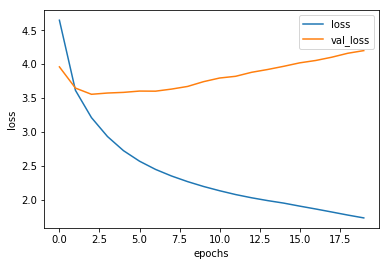

In [22]:
for label in ["loss","val_loss"]:
    plt.plot(model_history.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

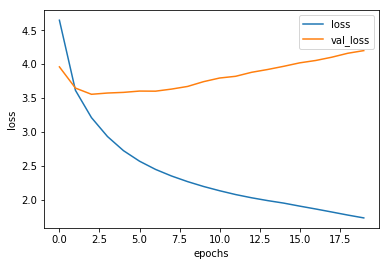

In [23]:
for label in ["loss","val_loss"]:
    plt.plot(model_history.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [24]:
tokenizer = Tokenizer(num_words=8000)
dcaptions = train["caption"].values
tokenizer.fit_on_texts(dcaptions)
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

In [25]:
def predict_caption(image):
    in_text = 'startseq'
    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([sequence,image],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)

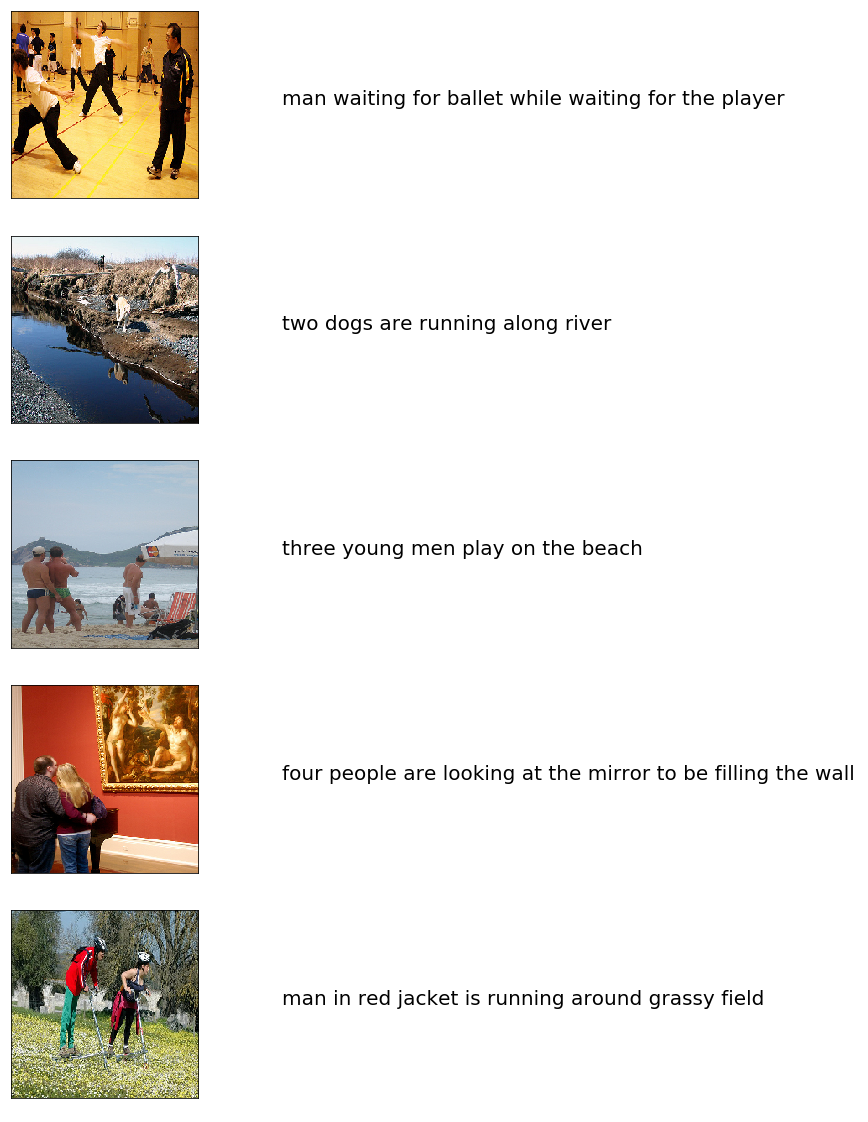

In [26]:
npic = 5

count = 1
fig = plt.figure(figsize=(10,20))
for i,row in val_data[:5].iterrows():
    jpgfnm = row["image"]
    image_feature = img_encoding[row["image"]]
    ## images 
    filename = image_url + jpgfnm
    image_load = load_img(filename, target_size=(224,224,3))
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))    
    caption = caption.replace("startseq ", "")
    caption = caption.replace("endseq", "")
    
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [27]:
nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 

test_img_encoding = extract_image(img_model,test["image"], image_url)
test, _, _ = word_tokenizer(test)
for i,row in test.iterrows():
    jpgfnm = row["image"]
    image_feature = test_img_encoding[row["image"]]
    tokenized_text = row["token_caption"]
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(test.shape[0])))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))        

Encoding image: 1000 (2048,)
vocabulary size : 3128
max length : 30


/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


  4.00% is done..
  8.00% is done..
  12.00% is done..
  16.00% is done..
  20.00% is done..
  24.00% is done..


/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


  28.00% is done..
  32.00% is done..
  36.00% is done..
  40.00% is done..
  44.00% is done..
  48.00% is done..
  52.00% is done..
  56.00% is done..
  60.00% is done..
  64.00% is done..
  68.00% is done..
  72.00% is done..
  76.00% is done..
  80.00% is done..
  84.00% is done..
  88.00% is done..
  92.00% is done..
  96.00% is done..
  100.00% is done..
Mean BLEU 0.326


Bad Caption


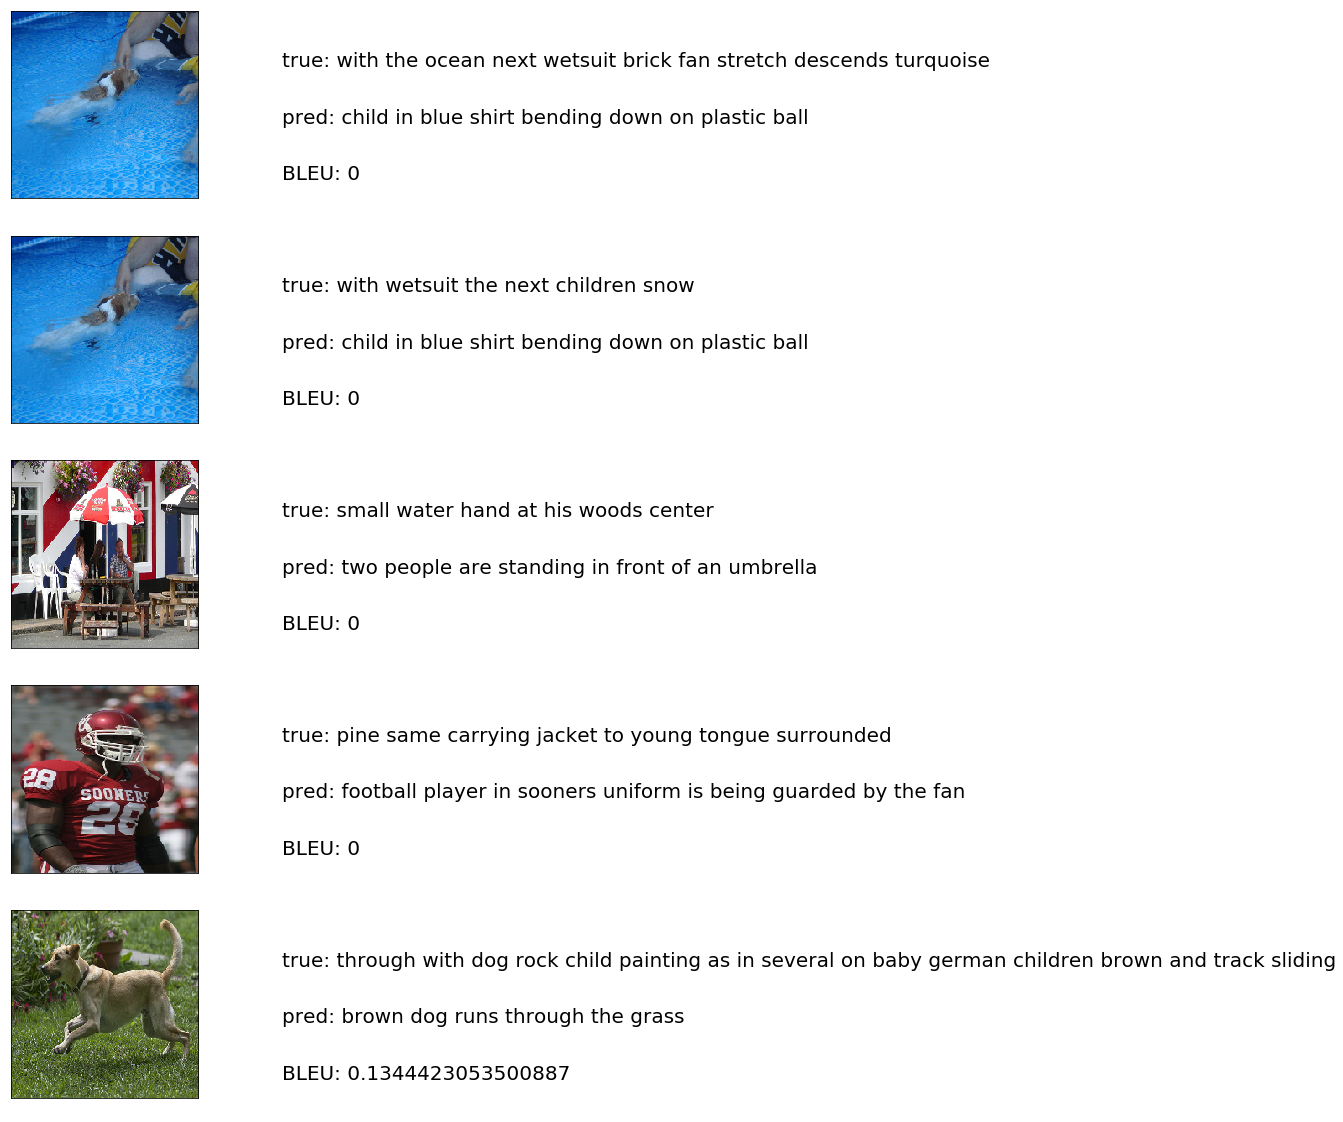

Good Caption


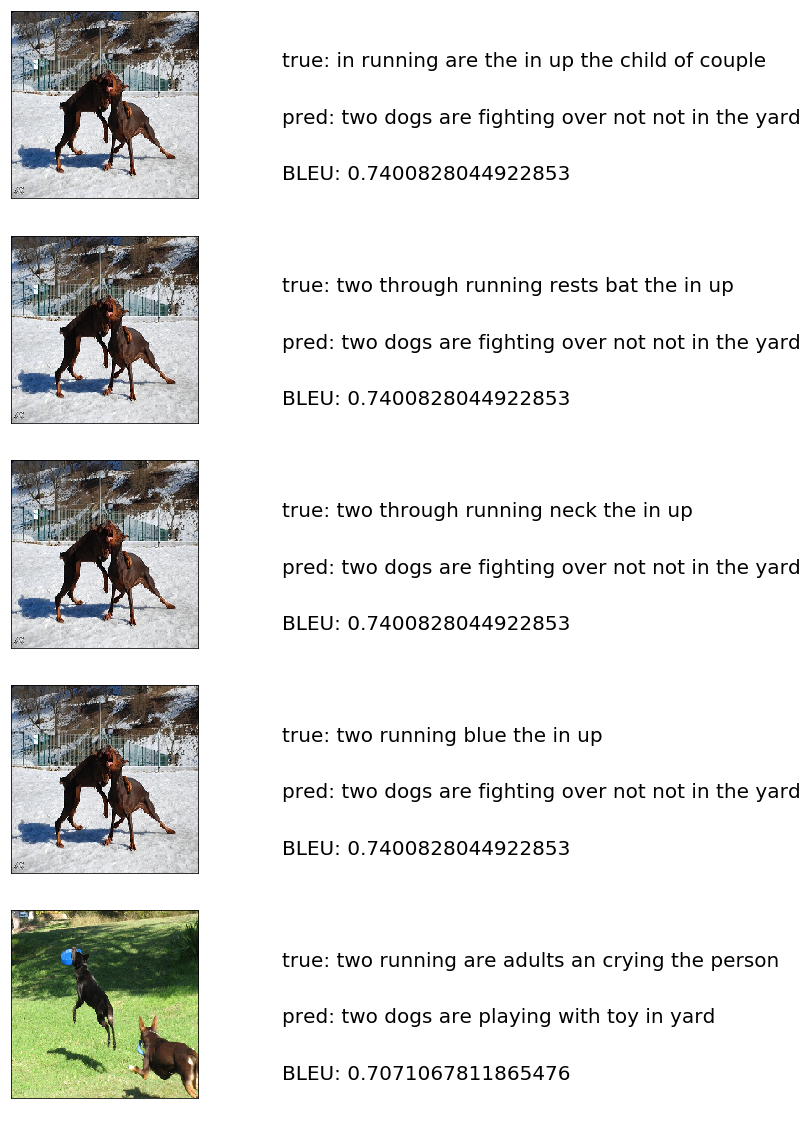

In [28]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = image_url + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good) 